This notebook takes the predictions made by the various models and calculates their performance.


In [1]:
import pandas as pd
from variables import PROJECTNAME_DATA_PATHS, SDG_MAP, ALL_EVAL_RESULTS_PATH
from file_org import iterdatatype_data
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def count_sdgs(data):
    sdg_counts = {k: 0 for k in SDG_MAP.keys()}
    total_rows = data.shape[0]

    for label_data in data["labels"]:
        for label in set(label_data):
            sdg_counts[label] += 1

    return sdg_counts, total_rows


all_results = []
for datatype in PROJECTNAME_DATA_PATHS.keys():
    for project_name, data in iterdatatype_data(datatype, "*"):
        sdg_counts, total_rows = count_sdgs(data)
        for sdg, sdg_count in sdg_counts.items():
            all_results.append(
                dict(
                    project_name=project_name,
                    sdg=sdg,
                    datatype=datatype,
                    total_rows=total_rows,
                    positive=sdg_count,
                    negative=total_rows - sdg_count,
                    pos_perc=sdg_count / total_rows,
                    neg_perc=(total_rows - sdg_count) / total_rows,
                )
            )

data_counts_df = pd.DataFrame(all_results)

model_performance = pd.read_json(ALL_EVAL_RESULTS_PATH, orient="records", lines=True)
merged = data_counts_df.merge(
    model_performance, how="inner", on=["sdg", "project_name", "datatype"]
)

merged.to_excel("../data/formatted_outputs/data_distribution.xlsx", index=False)
merged.head()

,project_name,sdg,datatype,total_rows,positive,negative,pos_perc,neg_perc,model_name,precision,recall,f1,TP,FP,TN,FN
0,2023_all_ugrad_outlines,SDG 1,raw,2350,48,2302,0.020426,0.979574,logistic_regression,1.000000,0.291667,0.451613,14,0,2302,34
1,2023_all_ugrad_outlines,SDG 1,raw,2350,48,2302,0.020426,0.979574,logistic_regression_subsampled,0.084615,0.916667,0.154930,44,476,1826,4
2,2023_all_ugrad_outlines,SDG 1,raw,2350,48,2302,0.020426,0.979574,uoft_dict_approach,0.087649,0.458333,0.147157,22,229,2073,26
3,2023_all_ugrad_outlines,SDG 2,raw,2350,50,2300,0.021277,0.978723,logistic_regression,0.937500,0.300000,0.454545,15,1,2299,35
4,2023_all_ugrad_outlines,SDG 2,raw,2350,50,2300,0.021277,0.978723,logistic_regression_subsampled,0.086716,0.940000,0.158784,47,495,1805,3


In [3]:
project = '2023_all_ugrad_outlines'
SDG_ORDER = SDG_MAP.keys()

data_filter = data_counts_df[data_counts_df["project_name"] == project]
display(data_filter.head())

model_filter = model_performance[(model_performance["project_name"] == project) & (model_performance["datatype"] == 'test')]
display(model_filter.head())

,project_name,sdg,datatype,total_rows,positive,negative,pos_perc,neg_perc
0,2023_all_ugrad_outlines,SDG 1,raw,2350,48,2302,0.020426,0.979574
1,2023_all_ugrad_outlines,SDG 2,raw,2350,50,2300,0.021277,0.978723
2,2023_all_ugrad_outlines,SDG 3,raw,2350,295,2055,0.125532,0.874468
3,2023_all_ugrad_outlines,SDG 4,raw,2350,205,2145,0.087234,0.912766
4,2023_all_ugrad_outlines,SDG 5,raw,2350,191,2159,0.081277,0.918723


,sdg,model_name,project_name,datatype,precision,recall,f1,TP,FP,TN,FN
1,SDG 1,logistic_regression,2023_all_ugrad_outlines,test,NaN,0.00000,NaN,0,0,460,10
5,SDG 1,logistic_regression_subsampled,2023_all_ugrad_outlines,test,0.061224,0.60000,0.111111,6,92,368,4
9,SDG 1,uoft_dict_approach,2023_all_ugrad_outlines,test,0.041667,0.20000,0.068966,2,46,414,8
13,SDG 10,logistic_regression,2023_all_ugrad_outlines,test,0.666667,0.53125,0.591304,34,17,389,30
17,SDG 10,logistic_regression_subsampled,2023_all_ugrad_outlines,test,0.423358,0.90625,0.577114,58,79,327,6


# Heatmap of training data

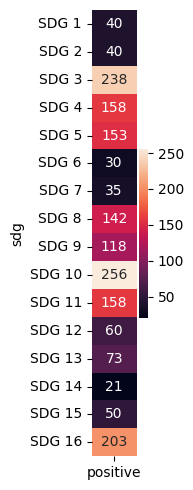

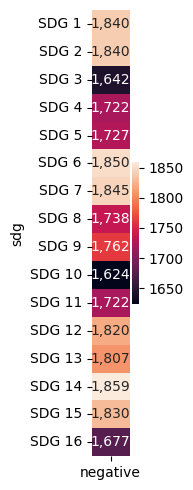

In [5]:
raw_data_counts = data_filter[(data_filter["datatype"] == "traindev")].drop_duplicates("sdg").set_index("sdg").reindex(SDG_ORDER)

plt.figure(figsize=(2,5))
sns.heatmap(raw_data_counts[["positive"]], annot=True, fmt=",.0f")
plt.tight_layout()
plt.savefig("../data/presentation_figures/n_pos.png", dpi=300)
plt.show()
plt.figure(figsize=(2,5))
sns.heatmap(raw_data_counts[["negative"]], annot=True, fmt=",.0f")
plt.tight_layout()
plt.savefig("../data/presentation_figures/n_neg.png", dpi=300)
plt.show()

# Heatmap of testing data

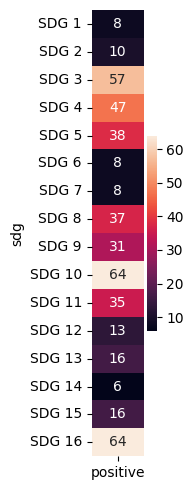

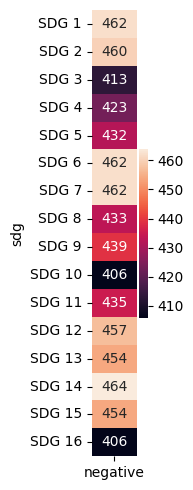

In [17]:
temp_reduced = data_filter[data_filter["datatype"] == 'test'].drop_duplicates("sdg").set_index("sdg").reindex(SDG_ORDER)

plt.figure(figsize=(2,5))
sns.heatmap(temp_reduced[["positive"]], annot=True, fmt=",.0f")
plt.tight_layout()
plt.savefig("../data/presentation_figures/test_n_pos.png", dpi=300)
plt.show()
plt.figure(figsize=(2,5))
sns.heatmap(temp_reduced[["negative"]], annot=True, fmt=",.0f")
plt.tight_layout()
plt.savefig("../data/presentation_figures/test_n_neg.png", dpi=300)
plt.show()

# Heatmap of model performance

logistic_regression


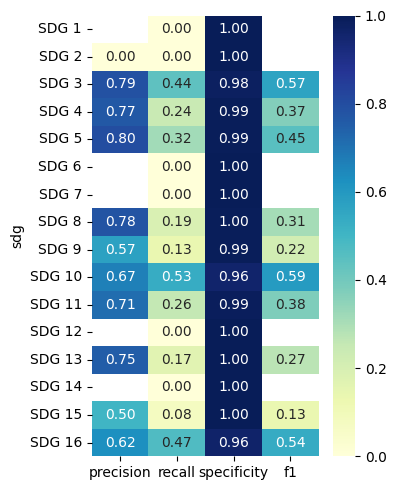

logistic_regression_subsampled


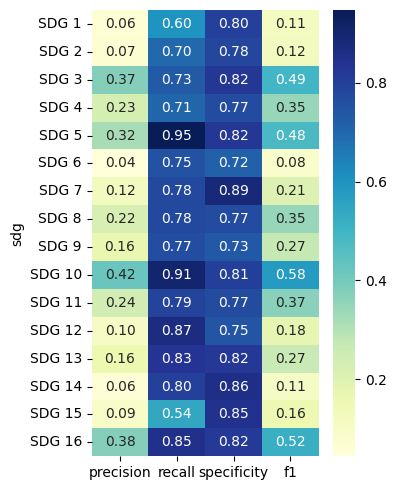

uoft_dict_approach


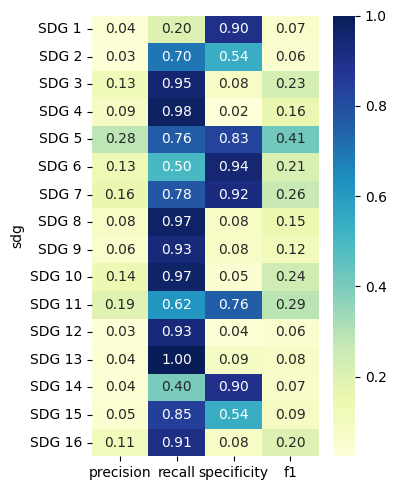

In [18]:
for model_name, group in model_filter.groupby("model_name"):
    group["specificity"] = group["TN"]/ (group["TN"] + group["FP"])
    prf1 = group[["sdg", 'precision', 'recall', 'specificity', 'f1']].set_index("sdg").reindex(SDG_ORDER)
    print(model_name)
    plt.figure(figsize=(4,5))
    sns.heatmap(prf1, cmap='YlGnBu', annot=True, fmt='.2f')
    plt.tight_layout()
    plt.savefig(f"../data/presentation_figures/{model_name}_performance.png", dpi=300)
    plt.show()